## **SETUP**

**Connecting Your Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Paths to the images and annotations**

In [2]:
path = "/content/drive/MyDrive/HardHatDetection/"
path_folder_annotations = f'{path}annotations'
path_folder_images = f'{path}obj'

## **Libraries**

In [23]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import albumentations as A
from xml.dom import minidom
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import Image
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

## **UTILS**

In [10]:
# Dictionary that maps class names to IDs
classMapping = {"helmet": 0,
                 "head": 1,
                 "person": 2}

**extractXmlInfo** : Extracts data from XML Annotation to a dictionary format, info_dict

In [5]:
def extractXmlInfo(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

**YoloBBFormatting** : Convert the info_dict from extractXmlInfo to the required yolo format and write it to disk

In [6]:
def YoloBBFormatting(info_dict, destPath):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = classMapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", classMapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = f"{destPath}/{info_dict['filename'].replace('png', 'txt')}"
    content = "\n".join(print_buffer)

    #Save the annotation to disk
    with open(save_file_name, 'w') as f:
      f.write(content)

**generateLabelTxt**: Generate the classes labels txt file

In [7]:
def generateLabelTxt(classMapping):
  classes = classMapping.keys()
          
  # Name of the file which we have to save 
  save_file_name = f"{path}/classes.txt"
  content = "\n".join(classes)

  #Save the annotation to disk
  with open(save_file_name, 'w') as f:
    f.write(content)

**extractAllXml**: Combines both extractXmlInfo and YoloBBFormatting into one function

In [8]:
def extractAllXml(df):
  for xmlFile in tqdm(df["annotationPath"].values):
    # Extracting the xml content
    info_dict = extractXmlInfo(xmlFile)
    # Storing all the bounding boxes txt to the image folder
    YoloBBFormatting(info_dict, path_folder_images)

**extractFilesPat**: Extracts file path with a specific extension from a selected folder

In [11]:
def extractFilesPath(path, extension):
  """
  DESCR
  -----
  Extracts file path with a specific extension from a selected folder

  path: Path to the folder
  extension: The extension of the interested file e.g .png, .jpg, .xml
  """
  files = []
  for i in tqdm(Path(path).glob(f'*{extension}')):
      files.append(i)
  files = sorted(files)
  return files

## **Creating csv files**

**Extracting the images path**

In [15]:
path_images = extractFilesPath(path_folder_images, '.png')

5000it [00:00, 18891.41it/s]


**Extracting the annotations path**

In [12]:
path_annotations = extractFilesPath(path_folder_annotations, '.xml')

5000it [01:22, 60.73it/s]


In [ ]:
len(path_images), len(path_annotations)

(5000, 5000)

**Exploratory Data Analysis**

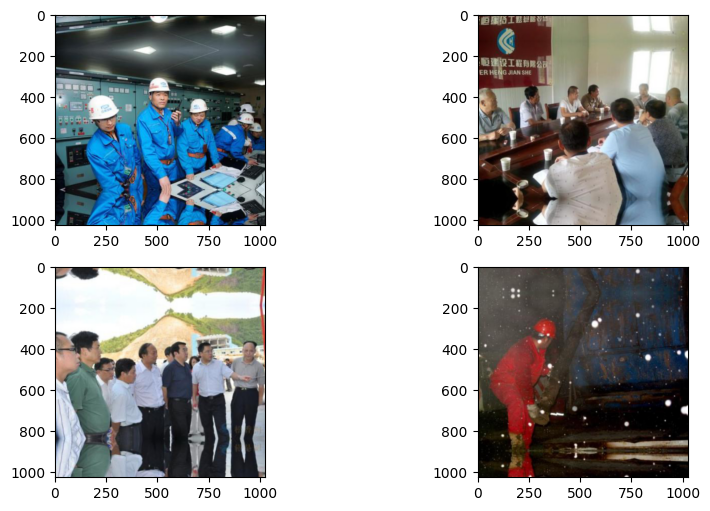

In [22]:
Nx_IMGS = 2
Ny_IMGS = 2

fig, ax = plt.subplots(Nx_IMGS,Ny_IMGS, figsize=(10,6))
ax = ax.reshape(-1)
for k,img in enumerate(range(Nx_IMGS*Ny_IMGS)):
    idx = np.random.randint(0, len(path_images))
    imgPath = f"{path_images[idx]}"
    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = A.Resize(1024,1024, p=1.0)(image=image)["image"]
    ax[k].imshow(image)
plt.show()

In [ ]:
dataDict = {"imagesPath":path_images, "annotationPath":path_annotations}
csvData = pd.DataFrame(dataDict)

In [ ]:
csvData["split"] = 1
csvData.loc[4500:, "split"] = 0

In [27]:
csvData["split"].value_counts()

1    4500
0     500
Name: split, dtype: int64

In [28]:
csvData.head()

,imagesPath,annotationPath,split
0,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...,1
1,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...,1
2,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...,1
3,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...,1
4,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...,1


**Create train and test dataframes**

In [29]:
train = csvData[csvData["split"].eq(1)].drop("split", axis=1).reset_index(drop=True)
test = csvData[csvData["split"].eq(0)].drop("split", axis=1).reset_index(drop=True)

In [32]:
train.shape, test.shape

((4500, 2), (500, 2))

In [30]:
train.head()

,imagesPath,annotationPath
0,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...
1,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...
2,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...
3,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...
4,/content/drive/MyDrive/HardHatDetection/obj/ha...,/content/drive/MyDrive/HardHatDetection/annota...


**Create a folder "input" to save the csv files**

In [33]:
!mkdir "/content/drive/MyDrive/HardHatDetection/input"

**Saving the train and test dataframe**

In [34]:
inputFolder = "/content/drive/MyDrive/HardHatDetection/input"

train.to_csv(f"{inputFolder}/train.csv", index=False)
test.to_csv(f"{inputFolder}/test.csv", index=False)

## **Testing Utils**

In [37]:
# Testing function
info_dict = extractXmlInfo(f'{path_folder_annotations}/hard_hat_workers0.xml')
print(info_dict)

{'bboxes': [{'class': 'helmet', 'xmin': 357, 'ymin': 116, 'xmax': 404, 'ymax': 175}, {'class': 'helmet', 'xmin': 4, 'ymin': 146, 'xmax': 39, 'ymax': 184}, {'class': 'helmet', 'xmin': 253, 'ymin': 139, 'xmax': 275, 'ymax': 177}, {'class': 'helmet', 'xmin': 300, 'ymin': 145, 'xmax': 323, 'ymax': 181}, {'class': 'helmet', 'xmin': 116, 'ymin': 151, 'xmax': 138, 'ymax': 180}, {'class': 'helmet', 'xmin': 80, 'ymin': 151, 'xmax': 100, 'ymax': 180}, {'class': 'head', 'xmin': 62, 'ymin': 144, 'xmax': 83, 'ymax': 172}, {'class': 'head', 'xmin': 322, 'ymin': 141, 'xmax': 345, 'ymax': 178}, {'class': 'head', 'xmin': 175, 'ymin': 156, 'xmax': 194, 'ymax': 186}, {'class': 'head', 'xmin': 222, 'ymin': 151, 'xmax': 240, 'ymax': 182}, {'class': 'head', 'xmin': 200, 'ymin': 146, 'xmax': 216, 'ymax': 173}, {'class': 'helmet', 'xmin': 98, 'ymin': 140, 'xmax': 112, 'ymax': 160}, {'class': 'head', 'xmin': 157, 'ymin': 150, 'xmax': 175, 'ymax': 177}], 'filename': 'hard_hat_workers0.png', 'image_size': (416, 

In [ ]:
#YoloBBFormatting(info_dict, path_folder_images)
YoloBBFormatting(info_dict, "/content/drive/MyDrive/HardHatDetection/")

In [ ]:
!cat "/content/drive/MyDrive/HardHatDetection/hard_hat_workers0.txt"

0 0.915 0.350 0.113 0.142
0 0.052 0.397 0.084 0.091
0 0.635 0.380 0.053 0.091
0 0.749 0.392 0.055 0.087
0 0.305 0.398 0.053 0.070
0 0.216 0.398 0.048 0.070
1 0.174 0.380 0.050 0.067
1 0.802 0.383 0.055 0.089
1 0.444 0.411 0.046 0.072
1 0.555 0.400 0.043 0.075
1 0.500 0.383 0.038 0.065
0 0.252 0.361 0.034 0.048
1 0.399 0.393 0.043 0.065

## **Extracting**

In [ ]:
extractAllXml(csvData)

100%|██████████| 5000/5000 [39:46<00:00,  2.10it/s]


In [ ]:
!ls -1 "/content/drive/MyDrive/HardHatDetection/obj" | wc -l

10000


In [41]:
generateLabelTxt(classMapping)

## **obj.names**
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

In [38]:
!mkdir "/content/drive/MyDrive/HardHatDetection/config"

In [39]:
# Creating the obj.names file in the drive
!touch "/content/drive/MyDrive/HardHatDetection/config/obj.names"

In [43]:
# Copying the content of classes.txt to obj.names
!cp "/content/drive/MyDrive/HardHatDetection/classes.txt" "/content/drive/MyDrive/HardHatDetection/config/obj.names"

## **obj.data**

**content**

- classes = 3
- train = data/train.txt
- valid = data/test.txt
- names = data/obj.names
- backup = /content/drive/MyDrive/HardHatDetection/backup

In [44]:
# Creating the obj.data file in the drive
!touch "/content/drive/MyDrive/HardHatDetection/config/obj.data"

In [ ]:
# Creating the backup folder in the drive
!mkdir "/content/drive/MyDrive/HardHatDetection/backup"

In [45]:
#Appending the necessary content to obj.data file
!echo -e "classes = 3\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/obj.names\nbackup = /content/drive/MyDrive/HardHatDetection/backup" > "/content/drive/MyDrive/HardHatDetection/config/obj.data"

## **Generating train.txt**
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

If everything went as planned double click on **train.txt** on the left side File Explorer and it should look like this.
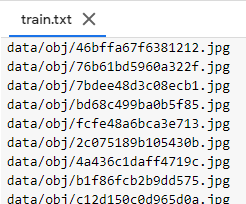

It will contain one line for each training image path.

In [46]:
image_files = []
for filename in train["imagesPath"].astype(str).values:
  image = f"{filename[44:]}"
  image_files.append("data/obj/" + image)

with open("/content/drive/MyDrive/HardHatDetection/config/train.txt", "w") as outfile:
  for image in image_files:
    outfile.write(image)
    outfile.write("\n")
  outfile.close()

In [47]:
image_files = []
for filename in test["imagesPath"].astype(str).values:
  image = f"{filename[44:]}"
  image_files.append("data/obj/" + image)

with open("/content/drive/MyDrive/HardHatDetection/config/test.txt", "w") as outfile:
  for image in image_files:
    outfile.write(image)
    outfile.write("\n")
  outfile.close()

In [48]:
!cat "/content/drive/MyDrive/HardHatDetection/config/test.txt"

data/obj/hard_hat_workers549.png
data/obj/hard_hat_workers55.png
data/obj/hard_hat_workers550.png
data/obj/hard_hat_workers551.png
data/obj/hard_hat_workers552.png
data/obj/hard_hat_workers553.png
data/obj/hard_hat_workers554.png
data/obj/hard_hat_workers555.png
data/obj/hard_hat_workers556.png
data/obj/hard_hat_workers557.png
data/obj/hard_hat_workers558.png
data/obj/hard_hat_workers559.png
data/obj/hard_hat_workers56.png
data/obj/hard_hat_workers560.png
data/obj/hard_hat_workers561.png
data/obj/hard_hat_workers562.png
data/obj/hard_hat_workers563.png
data/obj/hard_hat_workers564.png
data/obj/hard_hat_workers565.png
data/obj/hard_hat_workers566.png
data/obj/hard_hat_workers567.png
data/obj/hard_hat_workers568.png
data/obj/hard_hat_workers569.png
data/obj/hard_hat_workers57.png
data/obj/hard_hat_workers570.png
data/obj/hard_hat_workers571.png
data/obj/hard_hat_workers572.png
data/obj/hard_hat_workers573.png
data/obj/hard_hat_workers574.png
data/obj/hard_hat_workers575.png
data/obj/hard

## **Removing unused file**

In [ ]:
#Removing  the hard_hat_workers0.txt file
!rm "/content/drive/MyDrive/HardHatDetection/hard_hat_workers0.txt"

# Removing  the classes.txt file
!rm "/content/drive/MyDrive/HardHatDetection/classes.txt"

#Removing  the annotation folder
!rm -r "/content/drive/MyDrive/HardHatDetection/annotations"